# **Section:** Feature importance

In [1]:
import os
import itertools as it
import warnings
import time
import pickle

import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import joblib

import pathlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)

from sklearn import metrics

import tqdm

from libs.container import Container
from libs.nearest import nearest
from libs.experiment import WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

warnings.simplefilter("ignore", category=DataConversionWarning)

/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH = pathlib.Path(os.path.abspath(os.path.dirname("")))

DATA_PATH = PATH / "bkp"

COLUMNS_NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k', 'vs_type', 'vs_catalog', 'cls'] 

tiles = ["b234", "b360", "b278", "b261"]

In [3]:
%%time

path = "bkp/full_scaled.pkl.bz2"


train_datas = {}

sample = pd.read_pickle(path)

# the features
X_columns = [c for c in sample.columns if c not in COLUMNS_NO_FEATURES]
y_column = "cls"

sample[X_columns] =  sample[X_columns].astype(np.float32)

data = sample

del sample

CPU times: user 7min 7s, sys: 3min 34s, total: 10min 41s
Wall time: 1min 53s


In [4]:
%%time

path = "bkp/full.pkl.bz2"

full = pd.read_pickle(path)

full[X_columns] =  full[X_columns].astype(np.float32)

CPU times: user 2min 19s, sys: 4.31 s, total: 2min 23s
Wall time: 1min 22s


## Run the classifiers with the selected parameters

In [5]:
RF_PARAMS = joblib.load("_cache/best_params.pkl.bz2")["rf"]
if "n_jobs" in RF_PARAMS:
    del RF_PARAMS["n_jobs"]
RF_PARAMS

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 500}

In [8]:
%%time
if os.path.exists("_cache/feat_importance_b.pkl.bz2"):
    print("cache")
    clf = joblib.load("_cache/feat_importance_b.pkl.bz2")
else:
    clf = RandomForestClassifier(n_jobs=-1, oob_score=True, **RF_PARAMS)
    clf.fit(data[X_columns].values, data.cls.values)
    joblib.dump(clf, "_cache/feat_importance_b.pkl.bz2", compress=3)
    
clf

cache
CPU times: user 4.14 s, sys: 51.4 ms, total: 4.19 s
Wall time: 4.19 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [9]:
probabilities = clf.oob_decision_function_
prec, recs, thrs = metrics.precision_recall_curve(
        data.cls.values, probabilities[:,1], pos_label=1)

In [10]:
idx = nearest(recs, .9)
thr = thrs[idx]
thr, prec[idx], recs[idx]

(0.0043859649122807015, 0.017364080032623422, 0.890087660148348)

In [11]:
predictions = (probabilities[:,1] >= thr).astype(int)

In [12]:
df = pd.DataFrame({"cls": data.cls.values, "predictions": predictions})
df = df[df.cls == 1]
df["FP"] = (df.cls != df.predictions).astype(int)

In [13]:
df.describe()

,cls,predictions,FP
count,1483.0,1483.000000,1483.000000
mean,1.0,0.890088,0.109912
std,0.0,0.312886,0.312886
min,1.0,0.000000,0.000000
25%,1.0,1.000000,0.000000
50%,1.0,1.000000,0.000000
75%,1.0,1.000000,0.000000
max,1.0,1.000000,1.000000


## ponemos estas nuevas clases

In [14]:
data["predictions"] = predictions

# nos quedamos solo con las clases positivas
rr = data[data.cls == 1].copy()

# cambiamos "predictions" en FP y FN

def to_tpfn(row):
    return "TP" if row.predictions else "FN"
    

rr["clf_as"] = rr.apply(to_tpfn, axis=1)

In [15]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True, **RF_PARAMS)

In [16]:
clf.fit(rr[X_columns].values, rr.predictions.values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [17]:
fimp = pd.DataFrame({"Feature": X_columns, "Importance": clf.feature_importances_})
fimp = fimp.sort_values("Importance").reset_index()
fimp.tail()

,index,Feature,Importance
57,42,Psi_CS,0.039090
58,61,ppmb,0.042666
59,40,PeriodLS,0.062514
60,43,Psi_eta,0.076996
61,41,Period_fit,0.107361


In [18]:
from matplotlib.cbook import boxplot_stats    

In [19]:
if not os.path.exists("plots/s_fn"):
    os.makedirs("plots/s_fn")

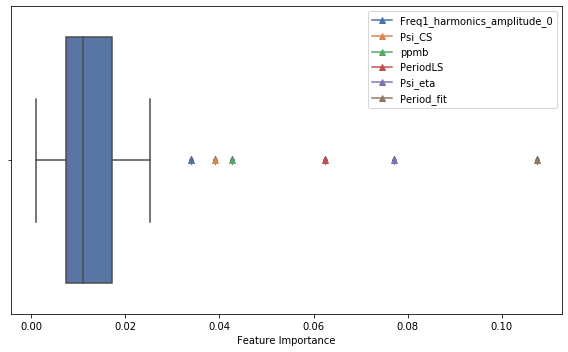

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

outliers = boxplot_stats(fimp.Importance)[0]["fliers"]
feat_outs = []

colors = sns.color_palette("deep", len(outliers) + 1)

sns.boxplot(fimp.Importance, ax=ax, color=colors[0])
for idx, flier in enumerate(outliers):
    feat = fimp[fimp.Importance == flier].Feature.values[0]
    feat_outs.append(feat)
    ax.plot([flier], [0], marker='^', label=feat, color=colors[idx])

ax.set_xlabel("Feature Importance")
ax.legend()

fig.tight_layout()

fig.savefig("plots/s_fn/boxplot.pdf")

In [21]:
def get_clf_as(sid):
    return rr[rr.id == sid].clf_as.values[0]

real_rr = full[full.id.isin(rr.id)].copy()
real_rr["clf_as"] = real_rr.id.apply(get_clf_as)
real_rr = real_rr[["id", "tile", "cnt", "cls", "clf_as", "vs_type"] + feat_outs]
real_rr;

In [22]:
outlimit = min(boxplot_stats(real_rr.PeriodLS.values)[0]['fliers'])
outlimit

0.97553897

In [23]:
real_rr = real_rr[real_rr.PeriodLS.between(0, outlimit)]
tp = real_rr[real_rr.clf_as == "TP"]
fn = real_rr[real_rr.clf_as == "FN"]

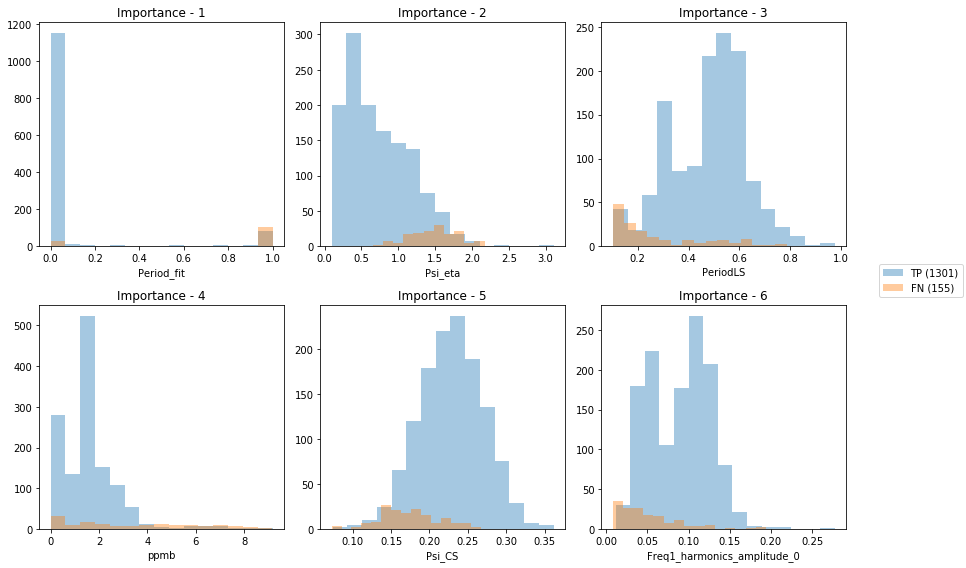

In [24]:
fig, axes = plt.subplots(2, int(len(feat_outs)/2), figsize=(12, 8))

bins=15; 
for idx, oname, ax in zip(range(len(feat_outs)), feat_outs[::-1], it.chain(*axes)):    
    tp_label, fn_label = (
        (f"TP ({len(tp)})", f"FN ({len(fn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(tp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
    sns.distplot(fn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
    ax.set_title(f"Importance - {idx+1}")
    
fig.legend(loc=7, bbox_to_anchor=(1.12, 0.5))
fig.tight_layout()

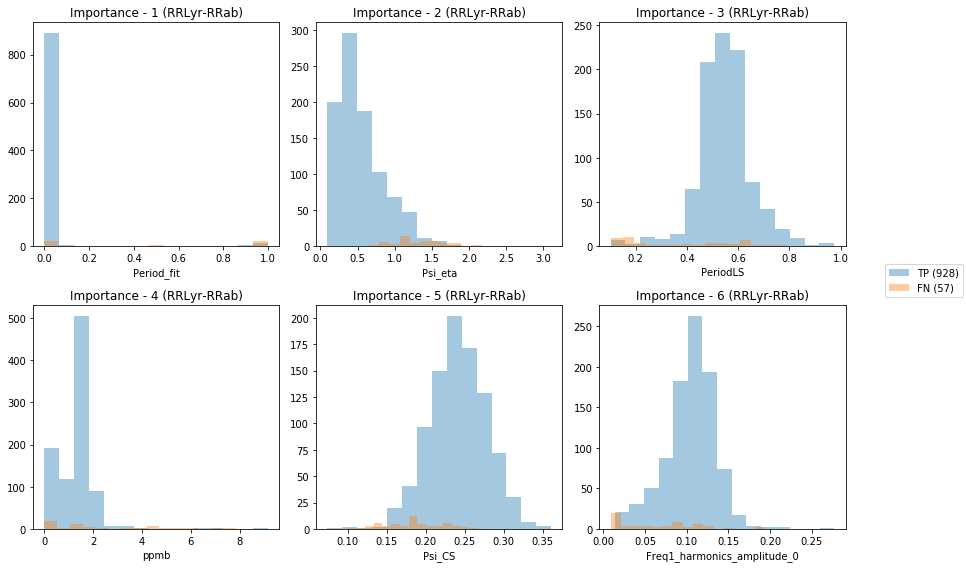

In [25]:
fig, axes = plt.subplots(2, int(len(feat_outs)/2), figsize=(12, 8))

bins=15; vs_type="RRLyr-RRab"
rrtp = tp[tp.vs_type == vs_type]
rrfn = fn[fn.vs_type == vs_type]
for idx, oname, ax in zip(range(len(feat_outs)), feat_outs[::-1], it.chain(*axes)):    
    tp_label, fn_label = (
        (f"TP ({len(rrtp)})", f"FN ({len(rrfn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(rrtp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
    sns.distplot(rrfn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
    ax.set_title(f"Importance - {idx+1} ({vs_type})")
    
fig.legend(loc=7, bbox_to_anchor=(1.12, 0.5))
fig.tight_layout()

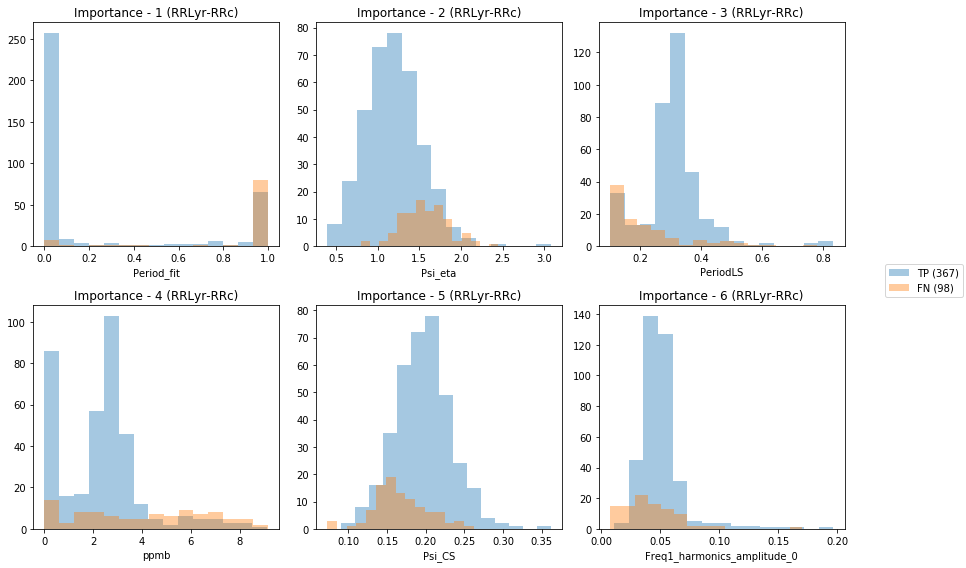

In [26]:
fig, axes = plt.subplots(2, int(len(feat_outs)/2), figsize=(12, 8))

bins=15; vs_type="RRLyr-RRc"
rrtp = tp[tp.vs_type == vs_type]
rrfn = fn[fn.vs_type == vs_type]
for idx, oname, ax in zip(range(len(feat_outs)), feat_outs[::-1], it.chain(*axes)):    
    tp_label, fn_label = (
        (f"TP ({len(rrtp)})", f"FN ({len(rrfn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(rrtp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
    sns.distplot(rrfn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
    ax.set_title(f"Importance - {idx+1} ({vs_type})")
    
fig.legend(loc=7, bbox_to_anchor=(1.12, 0.5))
fig.tight_layout()

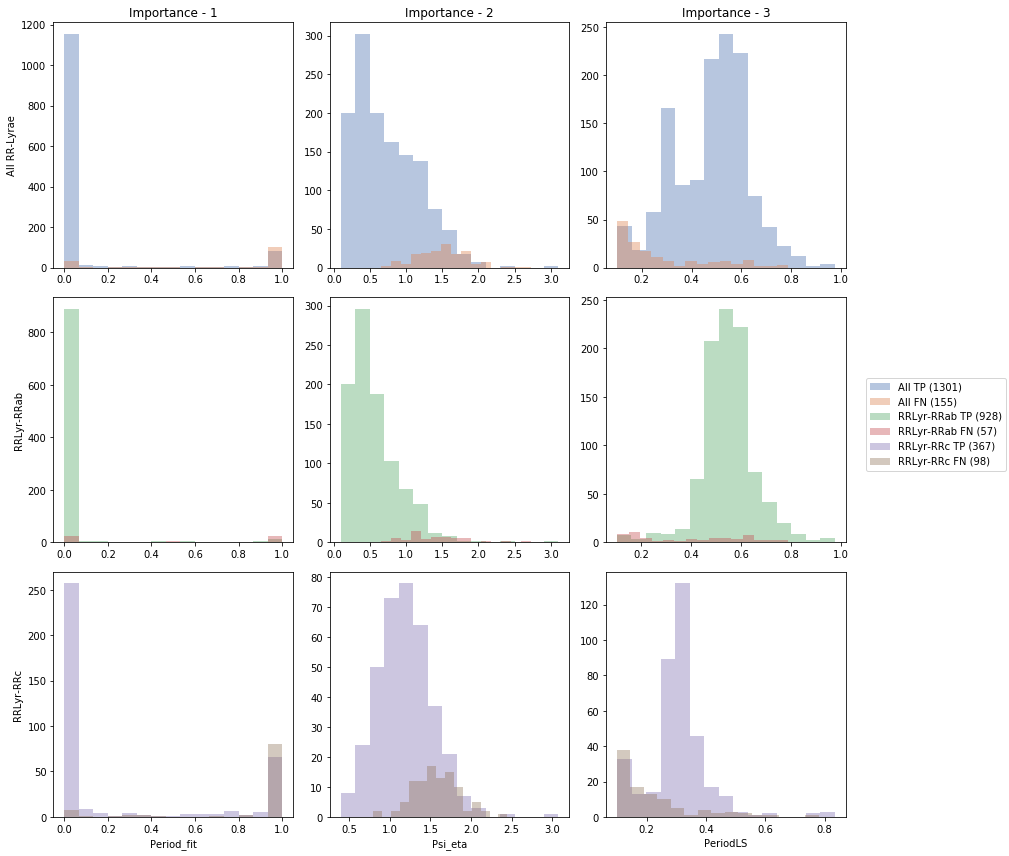

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

bins=15

colors = sns.color_palette("deep", 6)

ftplot = feat_outs[::-1][:3]
for idx, oname, ax in zip(range(3), ftplot, axes[0]):
    tp_label, fn_label = (
        (f"All TP ({len(tp)})", f"All FN ({len(fn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(tp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False, color=colors[0])
    sns.distplot(fn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False, color=colors[1])
    ax.set_title(f"Importance - {idx+1}")
    ax.set_xlabel("")
axes[0][0].set_ylabel("All RR-Lyrae")
    
vs_type = "RRLyr-RRab"
rrtp = tp[tp.vs_type == vs_type]
rrfn = fn[fn.vs_type == vs_type]
for idx, oname, ax in zip(range(3), ftplot, axes[1]):
    tp_label, fn_label = (
        (f"{vs_type} TP ({len(rrtp)})", f"{vs_type} FN ({len(rrfn)})")  
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(rrtp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False, color=colors[2])
    sns.distplot(rrfn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False, color=colors[3])
    ax.set_xlabel("")
axes[1][0].set_ylabel(vs_type)


vs_type = "RRLyr-RRc"
rrtp = tp[tp.vs_type == vs_type]
rrfn = fn[fn.vs_type == vs_type]
for idx, oname, ax in zip(range(3), ftplot, axes[2]):
    tp_label, fn_label = (
        (f"{vs_type} TP ({len(rrtp)})", f"{vs_type} FN ({len(rrfn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(rrtp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False, color=colors[4])
    sns.distplot(rrfn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False, color=colors[5])
    
axes[2][0].set_ylabel(vs_type)

lgd = fig.legend(loc=7, bbox_to_anchor=(1.17, 0.5))

fig.tight_layout()

fig.savefig("plots/s_fn/body_hist.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

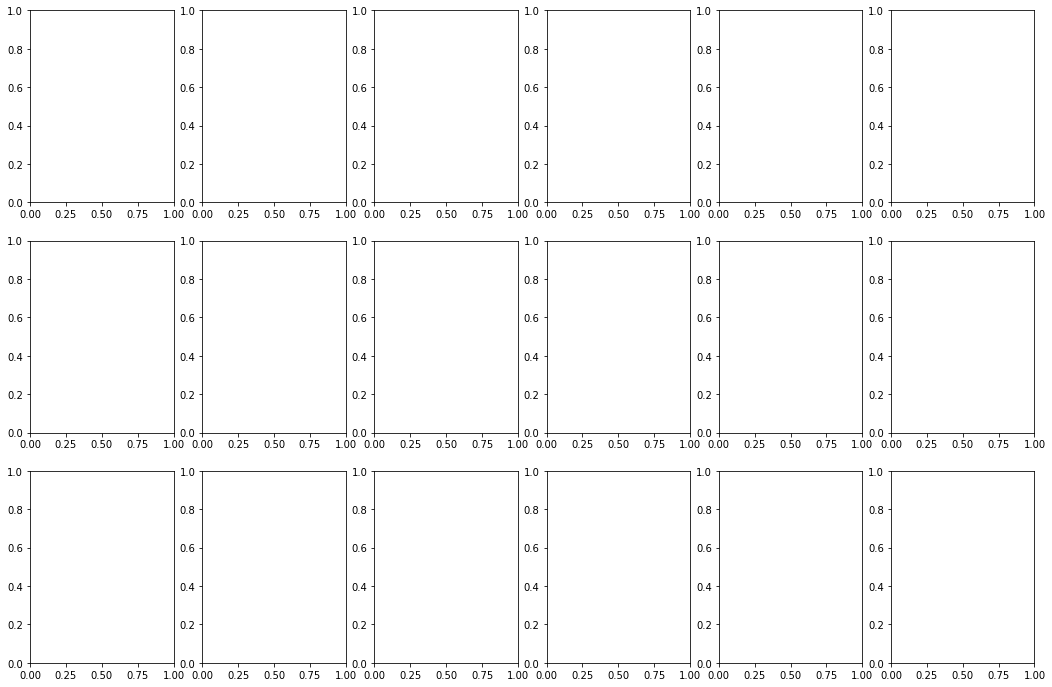

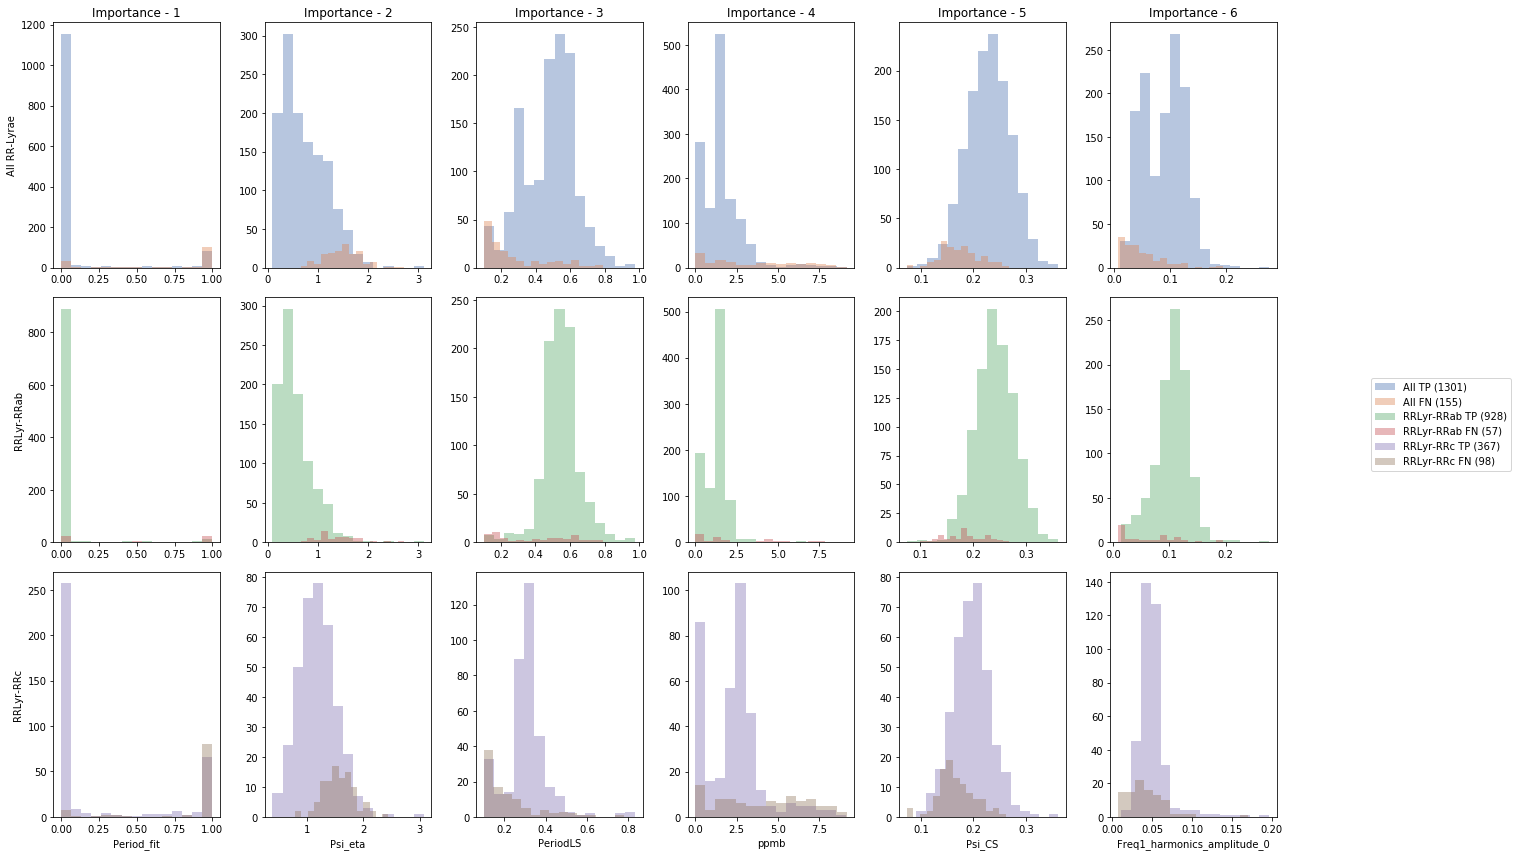

In [35]:
fig, axes = plt.subplots(3, 6, figsize=(18, 12))

bins=15

colors = sns.color_palette("deep", 6)

ftplot = feat_outs[::-1]
for idx, oname, ax in zip(range(6), ftplot, axes[0]):
    tp_label, fn_label = (
        (f"All TP ({len(tp)})", f"All FN ({len(fn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(tp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False, color=colors[0])
    sns.distplot(fn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False, color=colors[1])
    ax.set_title(f"Importance - {idx+1}")
    ax.set_xlabel("")
axes[0][0].set_ylabel("All RR-Lyrae")
    
vs_type = "RRLyr-RRab"
rrtp = tp[tp.vs_type == vs_type]
rrfn = fn[fn.vs_type == vs_type]
for idx, oname, ax in zip(range(6), ftplot, axes[1]):
    tp_label, fn_label = (
        (f"{vs_type} TP ({len(rrtp)})", f"{vs_type} FN ({len(rrfn)})")  
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(rrtp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False, color=colors[2])
    sns.distplot(rrfn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False, color=colors[3])
    ax.set_xlabel("")
axes[1][0].set_ylabel(vs_type)


vs_type = "RRLyr-RRc"
rrtp = tp[tp.vs_type == vs_type]
rrfn = fn[fn.vs_type == vs_type]
for idx, oname, ax in zip(range(6), ftplot, axes[2]):
    tp_label, fn_label = (
        (f"{vs_type} TP ({len(rrtp)})", f"{vs_type} FN ({len(rrfn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(rrtp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False, color=colors[4])
    sns.distplot(rrfn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False, color=colors[5])
    
axes[2][0].set_ylabel(vs_type)

lgd = fig.legend(loc=7, bbox_to_anchor=(1.17, 0.5))

fig.tight_layout()

fig.savefig("plots/s_fn/appendix_hist.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 8))

bins=15; 
# for idx, oname, ax in zip(range(len(feat_outs)), feat_outs[::-1], it.chain(*axes)):    
tp_label, fn_label = (f"TP ({len(tp)})", f"FN ({len(fn)})") 

sns.distplot(tp[tp.vs_type == "RRLyr-RRab"]["cnt"], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
sns.distplot(fn[fn.vs_type == "RRLyr-RRab"]["cnt"], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
    
# fig.legend(loc=7, bbox_to_anchor=(1.12, 0.5))
fig.tight_layout()

In [ ]:
fig, axis = plt.subplots(4, 6, figsize=(24, 18))
tile_axrows = zip(real_rr.tile.unique(), axis)


for tile, axrow in tile_axrows:
    tile_fn = fn[fn.tile == tile]
    tile_tp = tp[tp.tile == tile]
    
    tp_label, fn_label = (f"{tile} TP ({len(tile_tp)})", f"{tile} FN ({len(tile_fn)})") 
    
    for idx, oname, ax in zip(range(6), feat_outs[::-1], axrow):
        sns.distplot(tile_tp[oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
        sns.distplot(tile_fn[oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
        tp_label, fn_label = ("__nolegend__", "__nolegend__")
        if tile != real_rr.tile.unique()[-1]:
            ax.set_xlabel("")
    
    axrow[0].set_ylabel(tile)

    
    
lgd = fig.legend(loc=7, bbox_to_anchor=(1.17, 0.5))

fig.tight_layout()

# fig.savefig("plots/s_fn/body_hist.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
        